In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cv
import time
import gurobipy as gp
from gurobipy import GRB
import scipy

In [3]:
rng = np.random.default_rng(5438)

# Independent Birth Death's with regulation

As a simplification of the 'independent telegraphs with regulation' model, we consider the system:

$ \varnothing \stackrel{k_{1, tx}}\longrightarrow X_{1}  \quad\quad \varnothing \stackrel{k_{2, tx}}\longrightarrow X_{2} $

$ X_{1} \stackrel{k_{1, deg}}\longrightarrow  \varnothing \quad\quad X_{2} \stackrel{k_{2, deg}}\longrightarrow \varnothing $

$ X_{1} + X_{2} \stackrel{k_{reg}}\longrightarrow \varnothing $

with the state space $(x_{1}, x_{2}) \in \mathbb{N} \times \mathbb{N} $

## Simulation

Use gillespie / SSA to simulate sample paths of the reaction

In [4]:
def simulation(params, n, tmax, ts, plot=False, initial_state=(0, 0)):
    '''
    Simulate a sample path of the birth death regulation model
    Sample n values at intervals of ts after a burn-in time of tmax

    params: dict of reaction rate constants
    n: number of samples
    tmax: burn in time
    ts: time between samples
    '''

    # initialise time and state
    t = 0
    path = [initial_state]
    jump_times = [0]

    # simulate for burn-in time and time between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x1, x2 = path[-1][0], path[-1][1]

        # transition rates
        q_tx_1 = params['k_tx_1']
        q_tx_2 = params['k_tx_2']
        q_deg_1 = x1 * params['k_deg_1']
        q_deg_2 = x2 * params['k_deg_2']
        q_reg = x1 * x2 * params['k_reg']
        q_hold = q_tx_1 + q_tx_2 + q_deg_1 + q_deg_2 + q_reg

        # holding time in current state
        t_hold = -np.log(rng.uniform()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        outcome = [1, 2, 3, 4, 5]
        prob = [
            q_tx_1 / q_hold,
            q_tx_2 / q_hold,
            q_deg_1 / q_hold,
            q_deg_2 / q_hold,
            q_reg / q_hold
        ]
        jump = rng.choice(outcome, p=prob)
        match jump:
            case 1:
                path.append((x1 + 1, x2))
            case 2:
                path.append((x1, x2 + 1))
            case 3:
                path.append((x1 - 1, x2))
            case 4:
                path.append((x1, x2 - 1))
            case 5:
                path.append((x1 - 1, x2 - 1))

    # take the transcript states
    x1_path = [state[0] for state in path]
    x2_path = [state[1] for state in path]

    # create step function of sample path from jump times and jump values
    x1_path_function = scipy.interpolate.interp1d(jump_times, x1_path, kind='previous')
    x2_path_function = scipy.interpolate.interp1d(jump_times, x2_path, kind='previous')

    # take values at sampling times as samples from stationary dist
    sample_times = [tmax + i * ts for i in range(n)]
    x1_samples = x1_path_function(sample_times)
    x2_samples = x2_path_function(sample_times)
    samples = [(int(x1_samples[i]), int(x2_samples[i])) for i in range(n)]

    # plot sample paths
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, x1_path_function(x), label="X1 sample path", color="blue")
        plt.plot(x, x2_path_function(x), label="X2 sample path", color="purple")
        #plt.axvline(tmax, label="Burn-in time", color="orange")
        plt.xlabel("Time")
        plt.ylabel("# molcules")
        plt.legend()
        plt.show()

    return samples

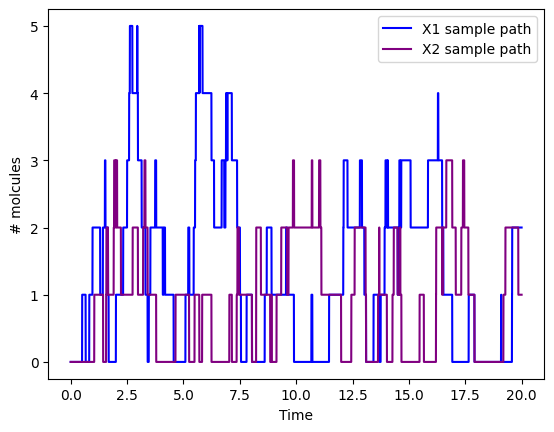

In [5]:
params = {
    'k_tx_1': 2,
    'k_tx_2': 2,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}
samples = simulation(params, 2, 10, 10, plot=True)

## Bootstrap

Produce 95% confidence intervals on the stationary probabilities $p(x_{1}, x_{2})$ for the states observed in the sample

In [55]:
def bootstrap(params, n, B, tmax=100, ts=10, thresh=1, plot=False, printing=False, initial_state=(0, 0)):
    '''
    Compute bootstrap confidence intervals on stationary distribution by 
    simulating sample path and computing empirical distribution over 
    several bootstrap samples

    params: dict of reaction rate constants
    n: number of samples from stationary distribution
    B: number of bootstrap resamples
    tmax: burn-in time for sampling
    ts: time between samples
    thresh: minimum occurnces of a state in the original sample to use the CI
        otherwise replaced by [0, 1] bounds
    plot: toggle plotting CI's
    printing: toggle printing CI's
    initial_state: starting point of sampling
    '''

    rng = np.random.default_rng(5438)

    # simulate n samples from stationary distribution
    samples = simulation(params, n, tmax, ts, plot=False, initial_state=initial_state)

    # compute maximum x1 and x2 values
    M = np.max([sample[0] for sample in samples])
    N = np.max([sample[1] for sample in samples])

    # map (x1, x2) pairs to integers: x2 + (N + 1) * x1
    integer_samples = [sample[1] + (N + 1)*sample[0] for sample in samples]

    # maxiumum of integer sample
    D = (M + 1)*(N + 1) - 1

    # B bootstrap samples as B x n array
    bootstrap = rng.choice(integer_samples, size=(B, n))

    # offset row i by (D + 1)i
    bootstrap_offset = bootstrap + np.arange(B)[:, None]*(D + 1)

    # flatten, count occurances of each state and reshape, reversing map to give counts of each (x1, x2) pair
    counts = np.bincount(bootstrap_offset.ravel(), minlength=B*(D + 1)).reshape(-1, M + 1, N + 1)

    # counts to probability
    counts = counts / n

    # sum over columns / rows to give counts of each x1 / x2 state
    x1_counts = counts.sum(axis=2)
    x2_counts = counts.sum(axis=1)

    # compute 2.5% and 97.5% quantiles for each p(x1, x2), p(x1) and p(x2)
    bounds = np.quantile(counts, [0.025, 0.975], axis=0)
    x1_bounds = np.quantile(x1_counts, [0.025, 0.975], axis=0)
    x2_bounds = np.quantile(x2_counts, [0.025, 0.975], axis=0)

    # count occurances per (x1, x2) in the in original sample
    sample_counts = np.bincount(integer_samples, minlength=D + 1).reshape(M + 1, N + 1)

    # sum over columns / rows to give counts per x1 / x2 state
    x1_sample_counts = sample_counts.sum(axis=1)
    x2_sample_counts = sample_counts.sum(axis=0)

    #sample_counts = np.zeros((M + 1, N + 1))
    #x1_sample_counts = np.zeros(M + 1)
    #x2_sample_counts = np.zeros(N + 1)

    # loop over original sample and add to counts
    #for i in range(n):
    #    x1, x2 = samples[i]
    #    sample_counts[x1, x2] += 1
    #    x1_sample_counts[x1] += 1
    #    x2_sample_counts[x2] += 1

    # replace CI's for states below threshold occurances by [0, 1] bounds
    for x1 in range(M + 1):
        for x2 in range(N + 1):
            if sample_counts[x1, x2] < thresh:
                bounds[:, x1, x2] = [0.0, 1.0]

    for x1 in range(M + 1):
        if x1_sample_counts[x1] < thresh:
            x1_bounds[:, x1] = [0.0, 1.0]

    for x2 in range(N + 1):
        if x2_sample_counts[x2] < thresh:
            x2_bounds[:, x2] = [0.0, 1.0]

    # plotting
    if plot:
        fig, axs = plt.subplots(M + 1, N + 1, figsize=(10, 10))
        fig.tight_layout()
        for x1 in range(M + 1):
            for x2 in range(N + 1):
                axs[x1, x2].hist(counts[:, x1, x2])
                axs[x1, x2].set_title(f"p({x1}, {x2})")
                axs[x1, x2].axvline(bounds[0, x1, x2], color="red")
                axs[x1, x2].axvline(bounds[1, x1, x2], color="red")

        plt.suptitle("X1 X2 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, M + 1, figsize=(10, 3))
        fig.tight_layout()
        for x1 in range(M + 1):
            axs[x1].hist(x1_counts[:, x1])
            axs[x1].set_title(f"p({x1})")
            axs[x1].axvline(x1_bounds[0, x1], color="red")
            axs[x1].axvline(x1_bounds[1, x1], color="red")

        plt.suptitle("X1 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, N + 1, figsize=(10, 3))
        fig.tight_layout()
        for x2 in range(N + 1):
            axs[x2].hist(x2_counts[:, x2])
            axs[x2].set_title(f"p({x2})")
            axs[x2].axvline(x2_bounds[0, x2], color="red")
            axs[x2].axvline(x2_bounds[1, x2], color="red")

        plt.suptitle("X2 Confidence Intervals")
        plt.show()

    return {'joint': bounds, 'x1': x1_bounds, 'x2': x2_bounds}

In [56]:
def bootstrap_old(params, n, B, tmax=100, ts=10, thresh=1, plot=False, printing=False, initial_state=(0, 0)):
    '''
    Compute bootstrap confidence intervals on the stationary distribution of system
    Simulate sample path and compute empirical distribution over each bootstrap sample

    params: dict of reaction rate constants
    n: number of samples from the stationary distribution
    B: number of bootstrap resamples
    tmax: burn-in time for sampling
    ts: time between samples
    thresh: minimum threshold of occurances of a state in the original sample for CI bounds to be used
         otherwise bounds are replaced by [0, 1]
    plot: toggle plotting CI's
    printing: toggle printing CI's
    initial_state: starting point of sampling
    '''

    rng = np.random.default_rng(5438)

    # n samples from stationary distribution
    samples = simulation(params, n, tmax, ts, plot=False, initial_state=initial_state)

    # separate x1 and x2 values (always considered paired, but for computational reasons)
    x1_samples = [sample[0] for sample in samples]
    x2_samples = [sample[1] for sample in samples]

    # maximum values found (+ 1)
    M = np.max(x1_samples) + 1
    N = np.max(x2_samples) + 1

    # array to count occurances per state in original sample
    sample_counts = np.zeros((M, N))
    x1_sample_counts = np.zeros(M)
    x2_sample_counts = np.zeros(N)

    # loop over original sample and add to counts
    for i in range(n):
        x1, x2 = samples[i]
        sample_counts[x1, x2] += 1
        x1_sample_counts[x1] += 1
        x2_sample_counts[x2] += 1

    # array to count occurances per state per bootstrap sample
    counts = np.zeros((B, M, N))
    x1_counts = np.zeros((B, M))
    x2_counts = np.zeros((B, N))

    # B bootstrap samples of size n in B x n array
    boot = rng.choice(samples, size=(B, n))

    # loop over each sample (row) and add to counts
    for b in range(B):
        for i in range(n):
            x1, x2 = boot[b, i]
            counts[b, x1, x2] += 1
            x1_counts[b, x1] += 1
            x2_counts[b, x2] += 1

    # normalize counts to probabilities
    counts /= n
    x1_counts /= n
    x2_counts /= n

    # take 2.5%, 97.5% percentiles for each p(x1, x2)
    # gives 2 x M x N array of lower and upper bounds (axis 0) for each p(x1, x2)
    bounds = np.quantile(counts, [0.025, 0.975], axis=0)
    x1_bounds = np.quantile(x1_counts, [0.025, 0.975], axis=0)
    x2_bounds = np.quantile(x2_counts, [0.025, 0.975], axis=0)

    # replace CI's for states below threshold occurances by [0, 1] bounds
    for x1 in range(M):
        for x2 in range(N):
            if sample_counts[x1, x2] < thresh:
                bounds[:, x1, x2] = [0.0, 1.0]

    for x1 in range(M):
        if x1_sample_counts[x1] < thresh:
            x1_bounds[:, x1] = [0.0, 1.0]

    for x2 in range(N):
        if x2_sample_counts[x2] < thresh:
            x2_bounds[:, x2] = [0.0, 1.0]

    # plotting
    if plot:
        fig, axs = plt.subplots(M, N, figsize=(10, 10))
        fig.tight_layout()
        for x1 in range(M):
            for x2 in range(N):
                axs[x1, x2].hist(counts[:, x1, x2])
                axs[x1, x2].set_title(f"p({x1}, {x2})")
                axs[x1, x2].axvline(bounds[0, x1, x2], color="red")
                axs[x1, x2].axvline(bounds[1, x1, x2], color="red")

        plt.suptitle("X1 X2 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, M, figsize=(10, 3))
        fig.tight_layout()
        for x1 in range(M):
            axs[x1].hist(x1_counts[:, x1])
            axs[x1].set_title(f"p({x1})")
            axs[x1].axvline(x1_bounds[0, x1], color="red")
            axs[x1].axvline(x1_bounds[1, x1], color="red")

        plt.suptitle("X1 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, N, figsize=(10, 3))
        fig.tight_layout()
        for x2 in range(N):
            axs[x2].hist(x2_counts[:, x2])
            axs[x2].set_title(f"p({x2})")
            axs[x2].axvline(x2_bounds[0, x2], color="red")
            axs[x2].axvline(x2_bounds[1, x2], color="red")

        plt.suptitle("X2 Confidence Intervals")
        plt.show()

    return {'joint': bounds, 'x1': x1_bounds, 'x2': x2_bounds}

In [57]:
bounds_old = bootstrap_old(params, 5000, 5000, thresh=10, plot=False)

In [58]:
bounds = bootstrap(params, 5000, 5000, thresh=10, plot=False)

Optimized code significantly faster: ~1 minute -> ~10 seconds

## Optimization

In [59]:
def optimization(params, bounds, N=None, M=None, K=10, silent=True, frechet=True, print_solution=True, test_feasible=False, param_bounds=None):
    '''
    Non-linear optimization to produce bounds on parameters of interest

    params: variable or fixed reaction rate constants
    bounds: 2 x M x N array of confidence interval bounds on stat. dist. of system
    silent: toggle printing of optimization status
    '''

    # create model
    md = gp.Model('birth-death-regulation')

    # set options
    if silent:
        md.Params.LogToConsole = 0

    # size
    if not M:
        M = bounds.shape[1]
    if not N:
        N = bounds.shape[2]

    # variables

    # stationary distribution
    p = md.addMVar(shape=(M, N), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

    # reaction rate constants
    rate_names = ['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg']
    rates = md.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

    # constraints

    # set fixed values
    for name, value in params.items():
        if value == "v":
            pass
        else:
            md.addConstr(rates[name] == value)

    # add any bounds given
    try:
        for name, value in param_bounds.items():
            md.addConstr(rates[name] <= value[1])
            md.addConstr(rates[name] >= value[0])
    except AttributeError:
        pass

    # stationary distribution bounds
    for x1 in range(M):
        for x2 in range(N):
            md.addConstr(p[x1, x2] >= bounds['joint'][0, x1, x2], name=f"lb {x1}, {x2}")
            md.addConstr(p[x1, x2] <= bounds['joint'][1, x1, x2], name=f"ub {x1}, {x2}")

            # additional frechet bounds
            if frechet:
                md.addConstr(p[x1, x2] >= bounds['x1'][0, x1] + bounds['x2'][0, x2] - 1, name=f"Frechet lb {x1}, {x2}")
                md.addConstr(p[x1, x2] <= bounds['x1'][1, x1], name=f"Frechet ub x1 {x1}, {x2}")
                md.addConstr(p[x1, x2] <= bounds['x2'][1, x2], name=f"Frechet ub x2 {x2}, {x2}")

    # distribution
    md.addConstr(p.sum() <= 1, name="Distribution")
    
    # stationary Qp=0 equations for all relevant variables
    for x1 in range(M - 1):
        for x2 in range(N - 1):
            if x1 == 0:
                x1_zero = 0
            else:
                x1_zero = 1
            if x2 == 0:
                x2_zero = 0
            else:
                x2_zero = 1

            md.addConstr(
                # remove terms when x1 or x2 = 0 since not in equation
                # so multiply by toggle
                rates['k_tx_1'] * x1_zero * p[x1 - 1, x2] + \
                rates['k_tx_2'] * x2_zero * p[x1, x2 - 1] + \
                rates['k_deg_1'] * (x1 + 1) * p[x1 + 1, x2] + \
                rates['k_deg_2'] * (x2 + 1) * p[x1, x2 + 1] + \
                rates['k_reg'] * (x1 + 1) * (x2 + 1) * p[x1 + 1, x2 + 1] - \
                (rates['k_tx_1'] + rates['k_tx_2'] + \
                 rates['k_deg_1'] * x1 + rates['k_deg_2'] * x2 + \
                 rates['k_reg'] * x1 * x2) * p[x1, x2] == 0,
                name=f"Equation {x1}, {x2}"
                )

    # solution dict
    solution = {}

    # optimize
    for name, value in params.items():

        # variable
        if value == "v":

            # minimize
            md.setObjective(rates[name], GRB.MINIMIZE)
            try:
                md.optimize()
                min_val = md.ObjVal
            except:
                min_val = None

            # maximize
            md.setObjective(rates[name], GRB.MAXIMIZE)
            try:
                md.optimize()
                max_val = md.ObjVal
            except:
                max_val = None

            # store
            solution[name] = [min_val, max_val]
    
        # constant
        else:
            solution[name] = value

    if test_feasible:
        # if testing feasibility simply optimize 1 to check
        md.setObjective(1, GRB.MINIMIZE)

        # set parameter (prevents 'infeasible or unbounded' ambiguity)
        md.Params.DualReductions = 0
        try:
            md.optimize()
            status_code = md.status
        except:
            status_code = md.status

        # decode status
        status_codes = {1: 'LOADED',
                        2: 'OPTIMAL',
                        3: 'INFEASIBLE',
                        4: 'INF_OR_UNBD',
                        5: 'UNBOUNDED',
                        6: 'CUTOFF',
                        7: 'ITERATION_LIMIT',
                        8: 'NODE_LIMIT',
                        9: 'TIME_LIMIT',
                        10: 'SOLUTION_LIMIT',
                        11: 'INTERRUPTED',
                        12: 'NUMERIC',
                        13: 'SUBOPTIMAL',
                        14: 'INPROGRESS',
                        15: 'USER_OBJ_LIMIT'}

        # store result
        solution['feasible'] = status_codes[status_code]

    # print
    if print_solution:
        for key, val in solution.items():
            if key == 'feasible':
                print(f"Model is {val}")
            elif type(val) == list:
                print(f"{key} in ({val[0]}, {val[1]})")
            else:
                print(f"{key} = {val}")

    # return model for IIS, etc
    solution['model'] = md

    return solution

In [64]:
# choose variable / fixed parameters for optimization
params_optim = {
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': "v",
    'k_deg_2': "v",
    'k_reg': 1
}

# optimize
solution = optimization(params_optim, bounds, M=5, N=5, silent=True)

k_tx_1 in (0.7449036863690399, 4.324057630316718)
k_tx_2 in (0.8802324058013319, 4.609979869189228)
k_deg_1 in (0.0, 3.539902484285069)
k_deg_2 in (0.0, 3.377715934508739)
k_reg = 1


## Example

In [65]:
# set simulation parameters
params_sim = {
    'k_tx_1': 2,
    'k_tx_2': 2,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}

# choose variable / fixed parameters for optimization
params_opt = {
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': "v",
    'k_deg_2': "v",
    'k_reg': params_sim['k_reg']
}

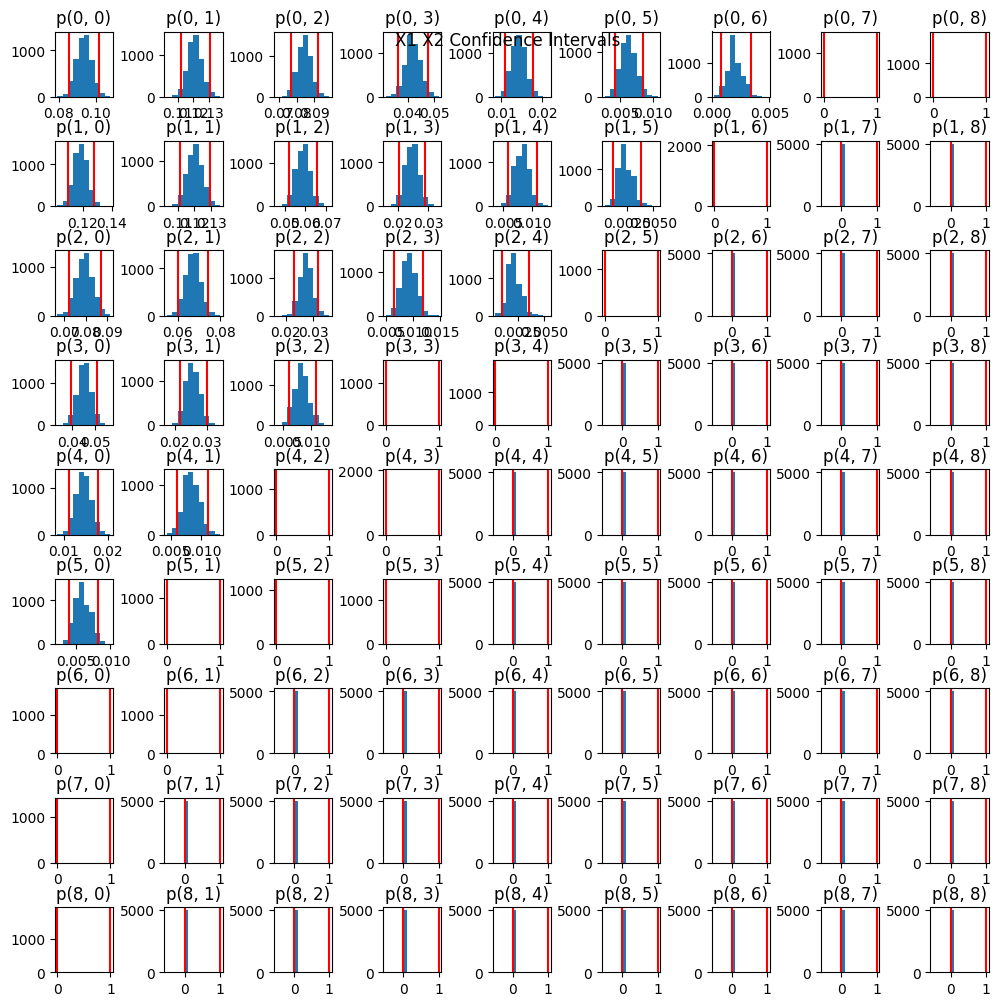

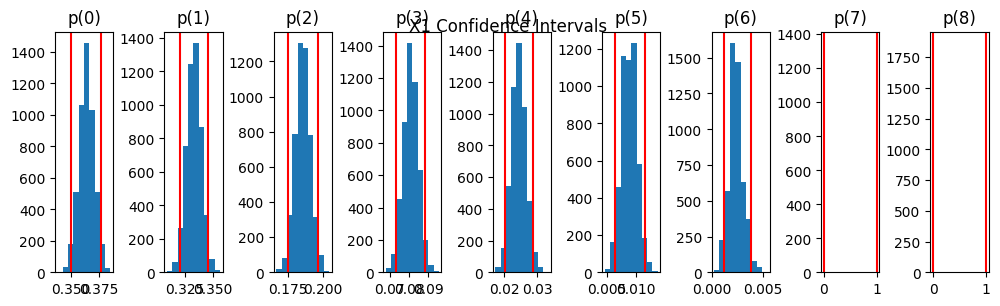

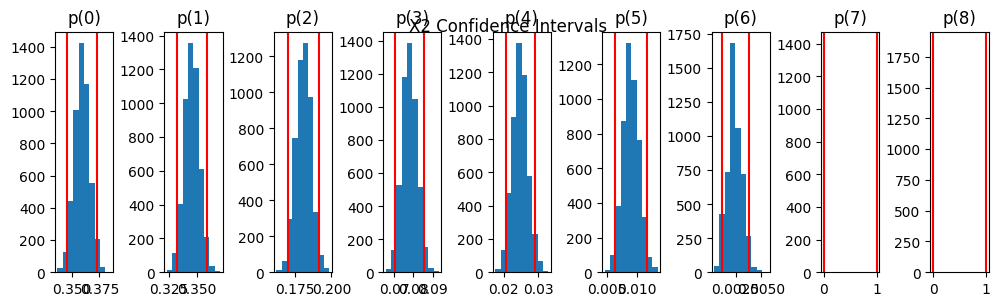

In [66]:
# bootstrap CI's
bounds = bootstrap(params_sim, 5000, 5000, thresh=10, plot=True)

In [68]:
# optimize
solution = optimization(params_opt, bounds, M=9, N=9, silent=True, test_feasible=True)

k_tx_1 in (0.8783801762510518, 3.550263090608561)
k_tx_2 in (0.9692385865697333, 3.6489883179863876)
k_deg_1 in (0.0, 2.369261856491447)
k_deg_2 in (0.05219998892208205, 2.4050016662930926)
k_reg = 1
Model is OPTIMAL


## Testing for interaction

Given simulated, or real, data from a reaction network we want to know if there is interaction between the 2 species of transcripts, or if they obey independent birth death processes i.e. $k_{deg} = 0$.

Method 1:

Fix a parameter of the reaction network for identifiability e.g. $k_{deg_2} = 1$ and optimize for $k_{reg}$. If the resulting bounds do not contain 0 (non-zero lower bound) this suggests there is interaction in the system, up to 95% confidence of the bounds used.

Method 2:

Assume as a null hypothesis there is no interaction, $H_{0}: k_{reg} = 0$, and so the stationary distribution factorises into 2 independent birth death stationary distributions:

$ p(x_1, x_2) = p(x_1)p(x_2) = Poi \left(\frac{k_{tx_1}}{k_{deg_1}} \right) Poi \left(\frac{k_{tx_2}}{k_{deg_2}} \right) $

Fixing 1 parameter in each of the ratios e.g. $k_{deg_1} = 1$ and $k_{deg_2} = 1 $, leaves the stationary distribution unchanged and so given only data from the stationary distribution allows identifiability of the parameters.

Fixing $k_{reg} = 0$, an infeasible solution suggests that the data is not consistent with a model of no interaction. However, a feasible solution to the optimization problem suggests there are parameter values that together with the data satisfy a model of no interaction, but does not confirm that there is no interaction. 

In [77]:
# parameter values for simulation: large regulation
params_simul = {
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 10
}
# fix regulation parameter to 0 (method 2)
params_optim_zero = {
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

# optimize over regulation parameter, fix another for identifiability (method 1)
params_optim_var = {
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': "v",
    'k_deg_2': 1,
    'k_reg': "v"
}

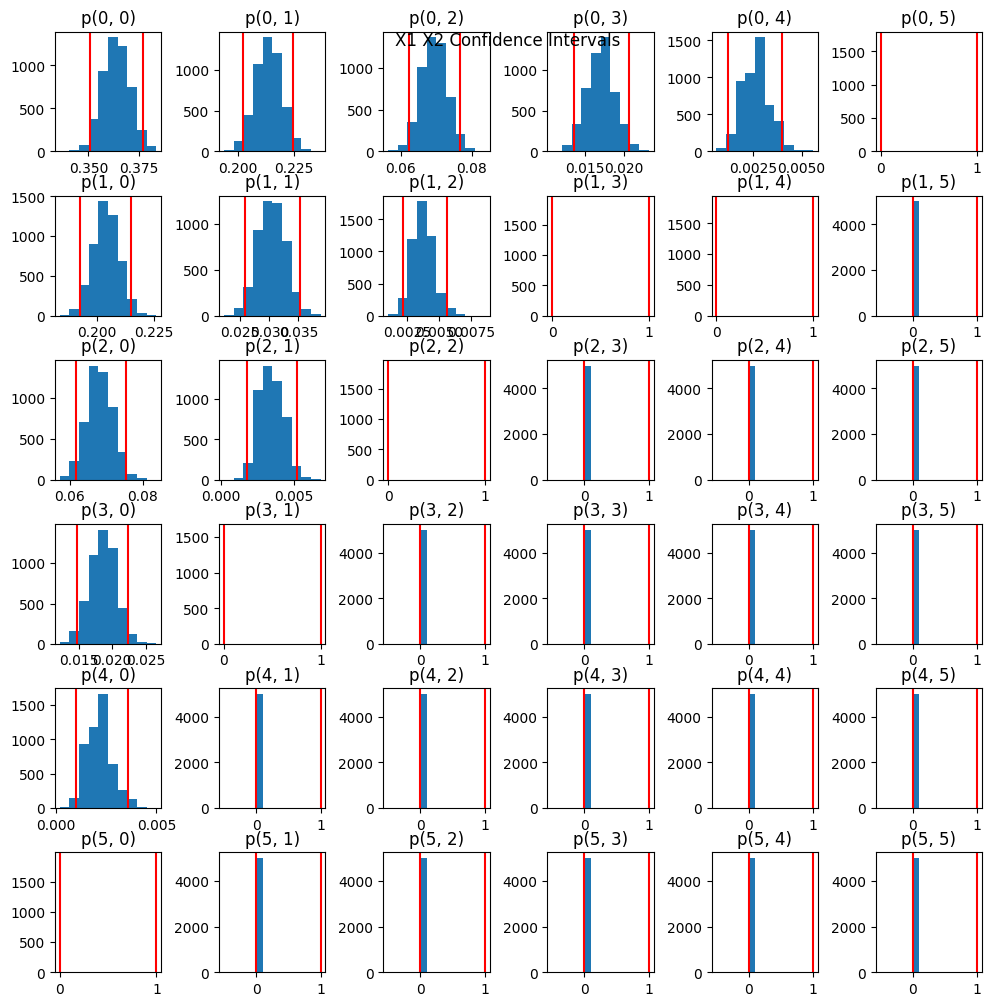

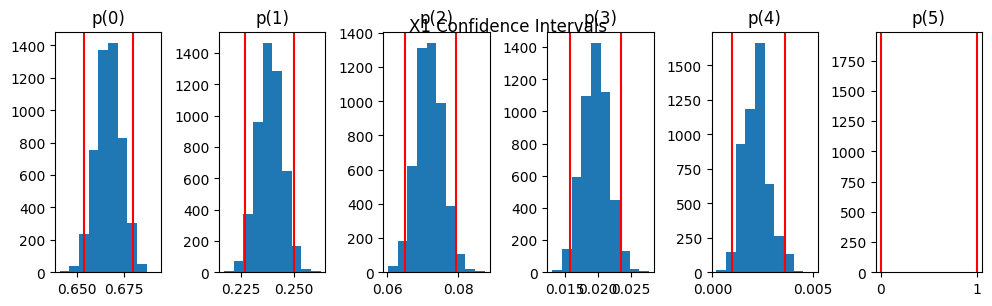

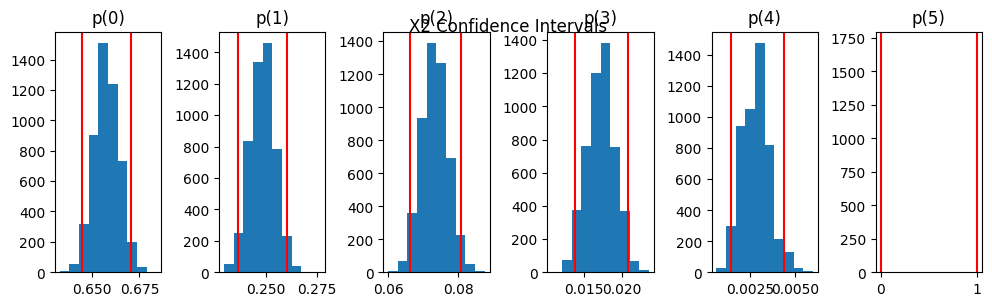

In [78]:
# simulate and bootstrap to produce CI bounds on stat. dist.
bounds_test = bootstrap(params_simul, 5000, 5000, thresh=10, plot=True)

In [80]:
# fix k_reg = 0, use data with high regulation
solution_test = optimization(params_optim_zero, bounds_test, M=6, N=6, K=20, silent=True, test_feasible=True)

k_tx_1 in (None, None)
k_tx_2 in (None, None)
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is INFEASIBLE


Infeasible, as expected for data simulated with interaction

In [82]:
# leave k_reg variable, use data with high regulation
solution_test = optimization(params_optim_var, bounds_test, M=6, N=6, K=20, silent=True)

k_tx_1 in (0.35780261236377, 2.4953414181218627)
k_tx_2 in (0.6968403478194767, 1.5585304604489567)
k_deg_1 in (0.19991225807276405, 3.2964965802123825)
k_deg_2 = 1
k_reg in (4.523206076719582, 20.0)


Bounds on $k_{reg}$ do not contain 0 which suggests there is interaction, as expected